# SYSID - Código de Exemplo

Aluno: Pedro Henrique Cardoso Paulo

Professor: Helon Ayala

## Objetivo

O objetivo do código aqui mostrado é apresentaar alguns conceitos básicos do proceesso de ajuste por mínimos quadrados. Esse nb pode servir de base para outras atividades com as devidas adaptações.

## Passo 0 - Inicializando o Nb

### 0.1 - Limpando memória, prompt e inicializando random seed

In [43]:
% MEC 2015 System identification
% Prof Helon Ayala

clc
clear
close all
rng(1) % permite reproducibilidade (indisponivel no octave 6 que usei)
random_seed = 1;
randn("seed", random_seed);

error: 'rng' undefined near line 1, column 1

The 'rng' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.


### 0.2 - Importando pacotes

In [44]:
pkg load control %pkg control: funcoes de transferencia e c2d

## Passo 1 - Carregando os dados

Nesse exemplo os dados serão simulados, logo não haverá importação. Para nosso exemplo usaremos um sistema massa-mola-amortecedo para gerar dados.

Importante notar que haverá dois conjuntos de dados: um conjunto de dados de treino, usado para ajuste do modelo, e um conjunto de dados de validação que será gerado pela mesma dinâmica, porém com excitações distintas.

### 1.1 - Definindo constantes do sistema e modelando função de transferência

In [45]:
%% - generate artificial data
% spring-mass-damper system

m = 0.1; b= 1; k = 10; % parameters
s = tf('s');
G = 1/(m*s^2+b*s+k); % continuous model
Ts = 0.01; % sampling time
Gd = c2d(G,Ts) % discrete model


Transfer function 'Gd' from input 'u1' to output ...

      0.0004833 z + 0.0004675
 y1:  -----------------------
      z^2 - 1.895 z + 0.9048 

Sampling time: 0.01 s
Discrete-time model.


Para o modelo definido, podemos ver pela função de transferência que os seguintes parâmetros são os relevantes para a dinâmica do sistema:

In [46]:
th = [-1.895 0.9048 0.0004833 0.0004675]'; % true vector of parameters

Espera-se que um ajuste por mínimos quadrados retorne um vetor $\theta$ similar ao descrito.

### 1.2 - Gerando dados sintéticos

Os dados serão gerados a partir da dinâmica do sistema, com a adição de um ruído branco.

In [47]:
% simulation parameters
N = 1000; % simulation steps
t = (1:N)'; % time vector
sig = 0.01; % noise corrupting measurements

In [48]:
% TRAINING
uamp = 10;
yr = 1;
u = uamp*ones(N,1);
y = zeros(N,1);
for k=3:N
    if y(k-1) >=  yr
        u(k) = -uamp;
    elseif y(k-1) <=  -yr
        u(k) = uamp;
    else
        u(k) = u(k-1);        
    end
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UTRA = u;
YTRA = y + sig*randn(N,1); % Addding white noise

### 1.3 - Visualizando os dados de treino

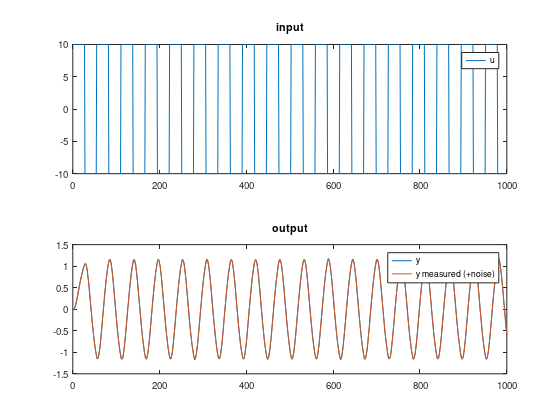

In [49]:
% plot training data
figure
subplot(2,1,1)
plot(t,UTRA)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YTRA y])
title('output')
legend('y','y measured (+noise)');

### 1.4 - Gerando dados de validação

In [50]:
% VALIDATION
u = uamp/4*sin(2*pi*t*Ts) + uamp/4*sin(pi*t*Ts) + uamp/4*sin(pi/2*t*Ts) + uamp/4*sin(pi/4*t*Ts);
y = zeros(N,1);
for k=3:N
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UVAL = u;
YVAL = y + sig*randn(N,1);

### 1.5 - Visualizando dados de validação

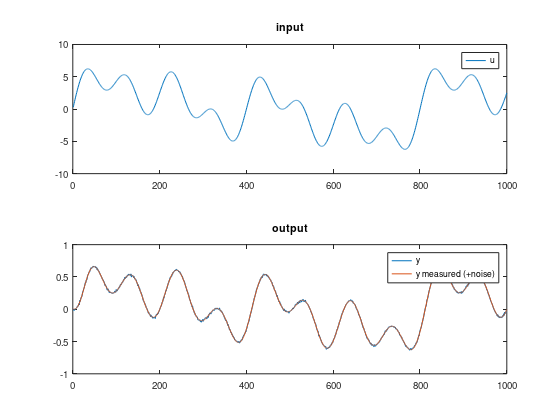

In [51]:
% plot validation data
figure
subplot(2,1,1)
plot(t,UVAL)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YVAL y])
title('output')
legend('y','y measured (+noise)');

## Parte 2 - Realizando ajuste

### 2.1 - Definindo funções úteis

#### 2.1.1 - Função para cálculo da matriz Phi

In [52]:
function [Phi, Y] = matReg (y, u, na, nb)
    % Funcao para a partir de um vetor de amostragem gerar as matrizes
    % para um processo de regressao linear
    %
    % Entradas
    %
    % y  = vetor de saidas (valores do sistema)
    % u  = vetor de entradas (perturbacoes externas)
    % na = numero de passos defasados de y
    % nb = numero de passos defasados de u
    %
    % Saidas
    %
    % Phi = Matriz para o ajuste
    % Y   = vetor resposta a ser ajustado
    
    p = max ([na, nb]) + 1;       % minimo tamanho das amostras
    end_val = length (y);         % tamanho do vetor de entrada
    
    Phi = [];

    % Loop 1 - Preenchendo com os valores atrasados de y
    for i=1:na
        Phi = [Phi -y(p-i:end_val-i)];
    endfor

    % Loop 2 - Preenchendo com os valores de u
    for i=1:nb
        Phi = [Phi u(p-i:end_val-i)];
    endfor

    Y = y(p:end_val);

endfunction

#### 2.1.2 - Função para simulação "One-step ahead" (OSA)

In [53]:
function y_pred = simulate_OSA (Phi, theta)
    % Funcao de simulacao one-step-ahead (OSA) de um sistema linear
    % Discreto
    %
    % Entradas
    %
    % Phi   = Matriz com os valores ajustados
    % theta = Vetor saida do ajuste linear
    %
    % Saidas
    %
    % y_pred = saida predita do sistemas

    y_pred = Phi*theta;

endfunction

#### 2.1.3 - Código para simulação livre ("Free simulation", FS)

In [54]:
function y_pred = simulate_FS (Phi, theta, u, na, nb)
    % Funcao de simulacao livre (FS) de um sistema linear
    % Discreto
    %
    % Entradas
    %
    % Phi   = Primeira linha da matriz a ser rodada
    % theta = Vetor saida do ajuste linear
    % u     = Vetor de forcamento total (partindo do tempo zero)
    % na    = Numero de passos anteriores considerados de y
    % nb    = Numero de passos anteriores considerados de u
    %
    % Saidas
    %
    % y_pred = saida predita do sistemas

    % limitando u
    p = max ([na, nb]) + 1;
    %nmax = length(u);
    u = u(p:end);

    % Inicializando y_pred
    y_pred = [];

    % Extraindo parcelas de phi que sao referentes a y e u
    Phi_y = Phi(1:na);
    Phi_u = Phi(na+1:na+nb);
    nmax = length(u);

    % Iterando no total de forcamentos
    for i=1:nmax
        y = [Phi_y Phi_u]*theta;
        y_pred = [y_pred; y];
        Phi_y = [-y Phi_y(1:na-1)];
        Phi_u = [u(i) Phi_u(1:nb-1)];
    endfor
    
endfunction

### 2.2 - Calculando matriz de regressão para ambos os trends

In [55]:
[Phi, Y1]    = matReg (YTRA, UTRA, 2, 2);
[PhiVAL, Y2] = matReg (YVAL, UVAL, 2, 2);

### 2.3 - Estimando os parâmetros

In [56]:
% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares
[th th_hat]

ans =

  -1.8950e+00  -1.7231e+00
   9.0480e-01   7.2943e-01
   4.8330e-04   7.3484e-04
   4.6750e-04   1.6444e-03



## Parte 3 - Comparação dos resultados

### 3.1 - Realizando a simulação

In [57]:
% one step ahead prediction
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, 2, 2);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, 2, 2);

#[yhat_VAL_OSA yhat_VAL_FS]

### 3.2 - Comparando conjunto de treino

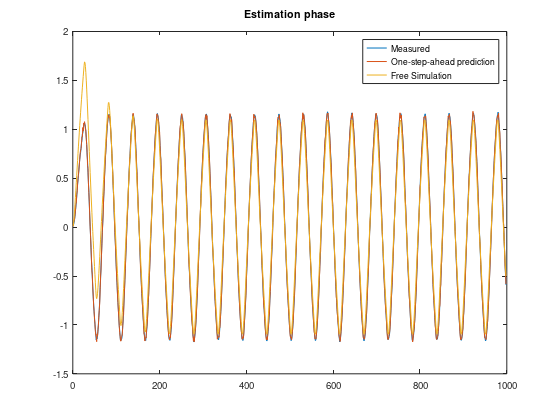

In [29]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.3 - Comparando resultados da validação

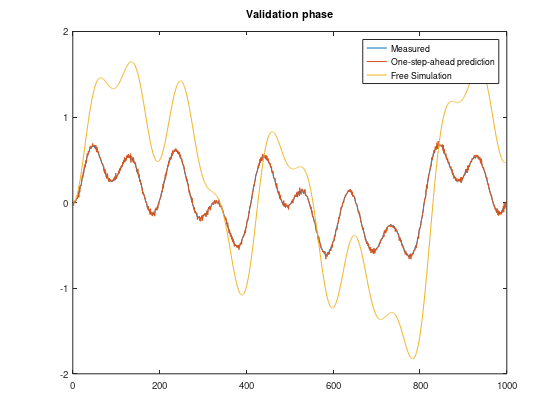

In [36]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.4 - Conclusões da comparação

A comparação dos resultados mostra que o resultado para o conjunto de treino foii razoável após o período de transiente. Já para o conjunto de validação, o resultado ficou aquém do esperado. Isso pode ser devido ao fato de o conjunto de treino ser inadequado para representar o conjunto de validação. Vamos tentar verificar isso.

## Parte 4 - Verificando o impacto do conjunto de validação

### 4.1 - Realizando ajuste

In [39]:
th_hat = (PhiVAL'*PhiVAL)^(-1)*PhiVAL'*Y2; % batch least squares
[th th_hat]

ans =

  -1.8950e+00  -4.3929e-01
   9.0480e-01  -3.1277e-01
   4.8330e-04  -1.7347e-01
   4.6750e-04   1.9828e-01



### 4.2 - Realizando simulações

In [40]:
% one step ahead prediction
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, 2, 2);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, 2, 2);

### 4.3 - Comparando resultados de treino (nova validação)

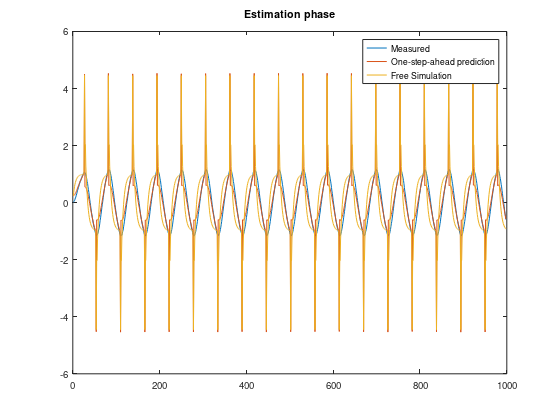

In [41]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 4.4 - Comparando os resultados de validação (novo treino)

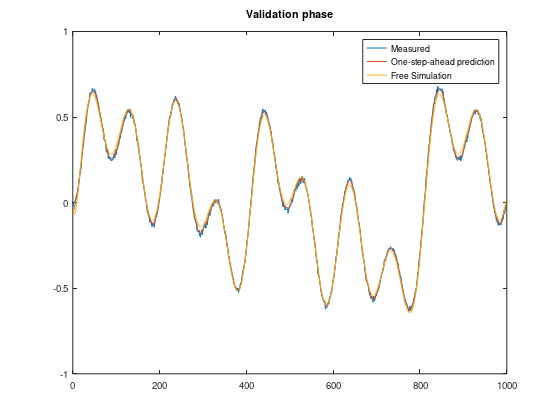

In [42]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

# Parte 5 - Conclusões

* Os resultados finais dependem do conjunto de dados usados para a entrada
* Simulações FS tendem a ter mais erros que simulações OSA
* O conjunto de treino sempre apresenta erros menores que o conjunto de validação